In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import yaml
import sys
import glob
import os
%matplotlib inline

In [28]:
sns.set(font_scale=1.1, style='white')
sns_cmap = sns.color_palette().as_hex()

In [29]:
def sum_cpu(node_res):
    """Return sum of CPU resources allocated to all nodes"""
    cpu = sum([v['cpu'] for v in node_res])
    return cpu

def read_placement(placement, df_data, flow_dr=250):
    """Read placement dict and write it to df_data. Then return."""
    df_data['num_flows'].append(placement['input']['num_flows'])
    df_data['num_sources'].append(placement['input']['num_sources'])
    df_data['source_dr'].append(placement['input']['num_flows'] * flow_dr)
    df_data['num_instances'].append(placement['metrics']['num_instances'])
    df_data['max_e2e_delay'].append(placement['metrics']['max_endToEnd_delay'])
    df_data['total_delay'].append(placement['metrics']['total_delay'])
    df_data['runtime'].append(placement['metrics']['runtime'])
    df_data['total_cpu'].append(sum_cpu(placement['placement']['alloc_node_res']))
    return df_data

def read_results(results):
    """Read result files matching the pattern and return df containing their metrics"""
    data = {'num_sources' : [], 'num_flows': [], 'source_dr': [], 'num_instances': [], 
            'max_e2e_delay': [], 'total_delay': [], 'runtime': [], 'total_cpu': []}

    # iterate through result files
    for res in glob.glob(results):
        # open and save metrics of interest
        with open(res, 'r') as f:
            placement = yaml.load(f, Loader=yaml.SafeLoader)
            data = read_placement(placement, data)

    return pd.DataFrame(data).sort_values(by=['num_flows'])

In [30]:
# read results
dataset = 'web_data'
sources = 'three_source_dr250'
results = f'placement_data/{dataset}/{sources}/'

df_true = read_results(results + 'true/*.yaml')
df_fixed = read_results(results + 'fixed/*.yaml')
df_linear = read_results(results + 'linear/*.yaml')
df_boost = read_results(results + 'boosting/*.yaml')
df_svr = read_results(results + 'svr/*.yaml')
df_ml = read_results(results + 'ml/*.yaml')

In [31]:
df_linear.head()

,num_sources,num_flows,source_dr,num_instances,max_e2e_delay,total_delay,runtime,total_cpu
0,3,3,750,9,60,60,0.265596,0.193674
2,3,6,1500,9,60,60,0.531128,0.738690
3,3,9,2250,9,60,60,1.305755,1.297319
4,3,12,3000,9,60,60,2.744371,1.855947
5,3,15,3750,9,60,60,2.175641,2.414575


In [32]:
def plot(x_col, x_label, y_col, y_label, save_plot=True, plot_fixed=True):
    sns.set(font_scale=1.1, style='white')
    fig, ax = plt.subplots()

    # use fixed colors for consistency with other plots (and more models)
#     plt.plot(df_true[x_col], df_true[y_col], label='True', color='black', marker='o')
    if plot_fixed:
        plt.plot(df_fixed[x_col], df_fixed[y_col], label='Fixed', color=sns_cmap[3], marker='+')
    plt.plot(df_linear[x_col], df_linear[y_col], label='Linear', color=sns_cmap[0], marker='x')
#     plt.plot(df_boost[x_col], df_boost[y_col], label='Boosting', color='red', marker='^')
#     plt.plot(df_svr[x_col], df_svr[y_col], label='SVR', color='orange', marker='v')
    plt.plot(df_ml[x_col], df_ml[y_col], label='SVR+Boosting', color=sns_cmap[2], marker='s')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend()
    
    # avoid cutting off figure labels
    plt.tight_layout()
    if save_plot:
        fig.savefig(f'plots/{dataset}_{y_col}.pdf')
        
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17deb6eb9e8>)

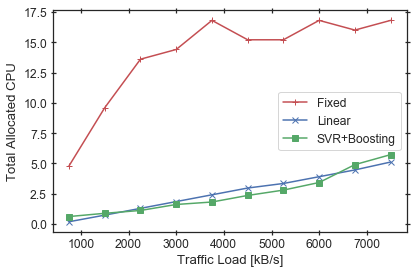

In [33]:
plot('source_dr', 'Traffic Load [kB/s]', 'total_cpu', 'Total Allocated CPU')

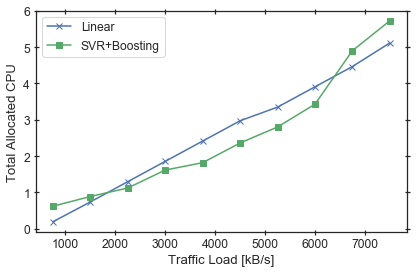

In [34]:
fig, ax = plot('source_dr', 'Traffic Load [kB/s]', 'total_cpu', 'Total Allocated CPU', plot_fixed=False)

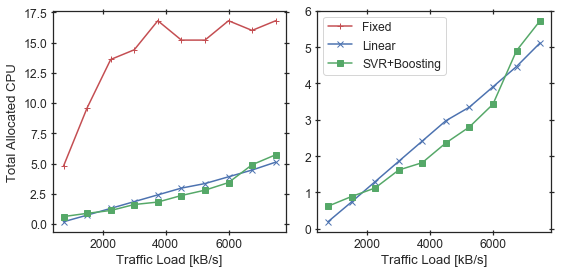

In [35]:
# plot both
def plot_both(x_col, x_label, y_col, y_label):
    sns.set(font_scale=1.1, style='white')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
    ax[0].plot(df_fixed[x_col], df_fixed[y_col], label='Fixed', color=sns_cmap[3], marker='+')
    ax[0].plot(df_linear[x_col], df_linear[y_col], label='Linear', color=sns_cmap[0], marker='x')
    ax[0].plot(df_ml[x_col], df_ml[y_col], label='SVR+Boosting', color=sns_cmap[2], marker='s')
    ax[0].set(xlabel=x_label, ylabel=y_label)
    ax[0].tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)

#     ax[0].legend()

    ax[1].plot([], [], label='Fixed', color=sns_cmap[3], marker='+')
    ax[1].plot(df_linear[x_col], df_linear[y_col], label='Linear', color=sns_cmap[0], marker='x')
    ax[1].plot(df_ml[x_col], df_ml[y_col], label='SVR+Boosting', color=sns_cmap[2], marker='s')
    ax[1].set(xlabel=x_label)
    ax[1].tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    ax[1].legend()
    
    # avoid cutting off figure labels
    plt.tight_layout()
    fig.savefig(f'plots/{dataset}_{y_col}_both.pdf')
    
plot_both('source_dr', 'Traffic Load [kB/s]', 'total_cpu', 'Total Allocated CPU')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17deb969978>)

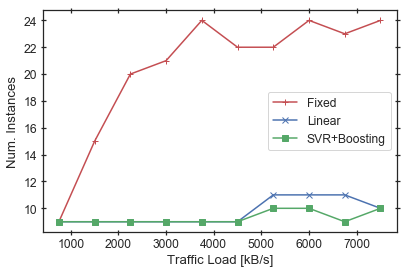

In [36]:
plot('source_dr', 'Traffic Load [kB/s]', 'num_instances', 'Num. Instances')

In [37]:
# max difference between different models
# max(df_linear['total_delay'] / df_ml['total_delay'])
# df_linear['total_delay'] / df_ml['total_delay']
df_linear['total_cpu'] / df_ml['total_cpu']
# max(df_ml['total_cpu'] / df_linear['total_cpu'])

0    0.311571
2    0.831388
3    1.154973
4    1.147946
5    1.326569
6    1.258852
7    1.195121
8    1.139511
9    0.910983
1    0.893397
Name: total_cpu, dtype: float64

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17deb9d1a20>)

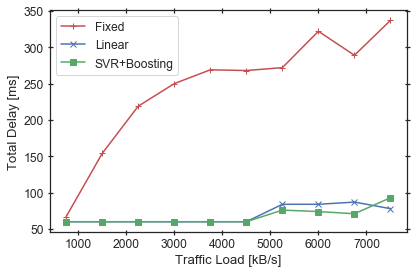

In [38]:
plot('source_dr', 'Traffic Load [kB/s]', 'total_delay', 'Total Delay [ms]')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17debb03fd0>)

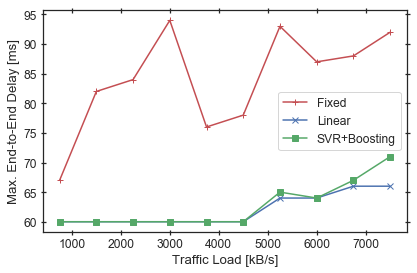

In [39]:
plot('source_dr', 'Traffic Load [kB/s]', 'max_e2e_delay', 'Max. End-to-End Delay [ms]')